In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 1
from imports import *
from functions import *
from database import engine, metadata

# Get Available Stations ID List

In [3]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()
# parse the response as a dictionary
stations_df = api.stations(as_df=True)

print(len(stations_df))

146


# Filter Buoys by Remarks

In [4]:
access_error_url_list = []

# Liste de mots √† rechercher dans la colonne "Remark"
blacklist = ["Failure", "ceased", "failed", "recovered", "stopped", 'adrift']
stations_id_set = set()

print(f'Avant Filtre: {stations_df.shape[0]}')

# Liste pour collecter les indices √† supprimer
indices_a_supprimer = []

# Parcours des lignes de la DataFrame
for idx, row in stations_df.iterrows():
    station_id = row["Station"]
    station_Location = row["Hull No./Config and Location"]  # Extraire la valeur de la cellule pour chaque ligne
    
    # Extraction du nom de la station si un ")" est trouv√©
    if ")" in station_Location:
        station_name = station_Location.split(')')[1].rstrip(" )")  # On enl√®ve l'espace et la parenth√®se en fin de cha√Æne
    else:
        station_name = station_Location.strip()  # Si pas de ")", on garde toute la cha√Æne

    station_name = station_name.rstrip(" )").replace("(", "").replace(")", "").strip()

    # Nettoyage final pour enlever toute parenth√®se ou espace en fin de nom
    station_name = station_name.rstrip(" )")

    # V√©rifier si "Remark" n'est pas NaN et si un des √©l√©ments de blacklist est dans "Remark"
    if isinstance(row["Remark"], str) and any(blacklist_word.lower() in row["Remark"].lower() for blacklist_word in blacklist):
        # Ajouter l'index √† la liste
        indices_a_supprimer.append(idx)
        url = get_buoy_url(station_id)
        access_error_url_list.append(url)
    else:
        pass
# Supprimer les lignes apr√®s la boucle
stations_df.drop(index=indices_a_supprimer, inplace=True)

print(f'Apr√®s Filtre: {stations_df.shape[0]}')

Avant Filtre: 146
Apr√®s Filtre: 45


# Build Buoys_datas Dict

In [5]:
# Dictionnaire pour stocker les DataFrames, cl√© : ID de la bou√©e, valeur : DataFrame
buoy_datas = {}
buoy_list = []

# Parcours de chaque bou√©e dans stations_df
for index, row in stations_df.iterrows():
    buoy_id = row['Station']
    metadata = get_station_metadata(buoy_id)

    # ‚úÖ R√©cup√©rer les donn√©es sous forme de dictionnaire
    buoy_info = parse_buoy_json(metadata)

    # ‚úÖ Stocker directement les donn√©es dans buoy_datas
    buoy_datas[buoy_id] = buoy_info
    buoy_list.append(buoy_id)

# Affichage du nombre de bou√©es r√©ussies et √©chou√©es
print(f"Nombre de bou√©es trait√©es : {len(buoy_datas)}\n")

# Afficher le contenu de buoy_datas

first_key =next(iter(buoy_datas))
first_key
buoy_datas[first_key]


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : grays reef
üÜî Station ID : 41008
‚úÖ Coordonn√©es extraites : Latitude = 31.40N, Longitude = 80.87W
üåä Water Depth : 16 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41008
‚úÖ Parsing termin√© !


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : ne st martin
üÜî Station ID : 41044
‚úÖ Coordonn√©es extraites : Latitude = 21.58N, Longitude = 58.63W
üåä Water Depth : 5419 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41044
‚úÖ Parsing termin√© !


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : south bermuda
üÜî Station ID : 41049
‚úÖ Coordonn√©es extraites : Latitude = 27.50N, Long

{'station_zone': 'grays reef',
 'lat_buoy': '31.40N',
 'lon_buoy': '80.87W',
 'Water_depth': '16 m',
 'sea_temp_depth': '2',
 'Barometer_elevation': '2.4',
 'Anemometer_height': '3.8',
 'Air_temp_height': '3.4',
 'url': 'https://www.ndbc.noaa.gov/station_page.php?station=41008'}

# Collecte de donn√©es marines et m√©t√©os

In [6]:
# üöÄ D√©marrage du processus
print("\nüöÄ D√©marrage du processus de collecte des donn√©es...\n")

# Initialisation des compteurs
marine_data_collected_successfully = marine_data_collected_failed = 0
meteo_data_collected_successfully = meteo_data_collected_failed = 0

success = False
total_stations = stations_df.shape[0]
count = 0

# üîÑ Parcours des bou√©es / stations
for idx, row in stations_df.iterrows():
    buoy_id = row["Station"]

    ######### üåä MARINE DATA #########
    try:
        df_marine = NDBC.realtime_observations(buoy_id)
        if df_marine is None or df_marine.empty:
            marine_data_collected_failed += 1
            continue

        marine_data_collected_successfully += 1
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur collecte marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    # Ajout des m√©tadonn√©es
    try:
        buoy_info = buoy_datas.get(buoy_id, {})
        Lat, Lon = buoy_info.get('lat_buoy'), buoy_info.get('lon_buoy')
        if Lat is None or Lon is None:
            raise ValueError(f"Donn√©es manquantes pour {buoy_id}")

        df_marine['Lat'] = Lat
        df_marine['Lon'] = Lon
        df_marine['Water_depth'] = buoy_info.get('Water_depth', None)
        df_marine.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_marine.columns]
        df_marine['Datetime'] = df_marine['Datetime'].dt.tz_localize(None)

        buoy_datas[buoy_id]["Marine"] = df_marine

        station_zone = safe_get(parse_buoy_json(get_station_metadata(buoy_id)), "station_zone")
        Bronze_Marine_table_Name = f"br_{buoy_id}_marine_{station_zone}".replace('.', '_').replace('-', '_').replace(' ', '_').lower()

    except Exception as e:
        print(f"‚ö†Ô∏è Erreur m√©tadonn√©es marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    ######### ‚õÖ METEO DATA #########
    try:
        df_meteo = meteo_api_request([Lat, Lon])
        if df_meteo is None or df_meteo.empty:
            meteo_data_collected_failed += 1
            continue
        
        rename_columns(df_meteo, {'date':'Datetime'})
        df_meteo.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_meteo.columns]
        df_meteo['Datetime'] = df_meteo['Datetime'].dt.tz_localize(None)
    
        buoy_datas[buoy_id]["Meteo"] = df_meteo
        meteo_data_collected_successfully += 1
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur collecte m√©t√©o {buoy_id}: {e}")
        meteo_data_collected_failed += 1
        continue

# Retirer les bou√©es avec des DataFrames vides ou None
buoy_datas = {buoy_id: data for buoy_id, data in buoy_datas.items() 
              if "Marine" in data and data["Marine"] is not None and not data["Marine"].empty
              and "Meteo" in data and data["Meteo"] is not None and not data["Meteo"].empty}

# üîö R√©sum√© final

print("\nüìù R√©sum√© final :")
print(f"üåä Marine - Collecte ‚úÖ {marine_data_collected_successfully} ‚ùå {marine_data_collected_failed}")
print(f"‚õÖ M√©t√©o - Collecte ‚úÖ {meteo_data_collected_successfully} ‚ùå {meteo_data_collected_failed}")

# Afficher la longueur du dictionnaire (nombre de bou√©es avec des donn√©es valides)
print(f"\nüìä Nombre de bou√©es avec des donn√©es valides : {len(buoy_datas)}")


üöÄ D√©marrage du processus de collecte des donn√©es...


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : grays reef
üÜî Station ID : 41008
‚úÖ Coordonn√©es extraites : Latitude = 31.40N, Longitude = 80.87W
üåä Water Depth : 16 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41008
‚úÖ Parsing termin√© !

üìä station_zone : grays reef
üîÑ Colonne 'date' renomm√©e en 'Datetime'
‚úÖ Colonnes renomm√©es : {'date': 'Datetime'}

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : ne st martin
üÜî Station ID : 41044
‚úÖ Coordonn√©es extraites : Latitude = 21.58N, Longitude = 58.63W
üåä Water Depth : 5419 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41044

# Data Enrichment with MetaDatas

In [7]:
list_not_include = ['lon_buoy', "lat_buoy", "url"]
for buoy_id, value in buoy_datas.items():
    print(f"\nüîç Traitement de la Station ID: {buoy_id}")

    marine_df = buoy_datas[buoy_id]["Marine"]
    meteo_df = buoy_datas[buoy_id]["Meteo"]

    try:
        # R√©cup√©rer les m√©tadonn√©es de la station
        buoy_metadata = get_station_metadata(buoy_id)
        parsed_data = parse_buoy_json(buoy_metadata)

        # Mise √† jour du dictionnaire avec les m√©tadonn√©es
        data = buoy_datas[buoy_id]
        data.update(parsed_data)
        
        # Ajouter les m√©tadonn√©es comme nouvelles colonnes dans marine_df
        if marine_df is not None:
            marine_df["Station ID"] = str(buoy_id)
            for key, value in parsed_data.items():
                # V√©rifier si la cl√© n'est pas dans la liste des exclusions
                if key not in list_not_include:
                    marine_df[key] = value
                    print(f"‚úÖ Colonne '{key}' ajout√©e au DataFrame de la station {buoy_id}")

    except Exception as e:
        print(f"‚ùå Erreur pour la station {buoy_id}: {e}")

# V√©rification de l'ajout des colonnes en prenant un id au hasard
station_id = random.choice(list(buoy_datas.keys()))
marine_df = buoy_datas[station_id]["Marine"]

if marine_df is not None:
    print("\nColonnes ajout√©es au DataFrame de la station", station_id)
    print(marine_df.columns)


üîç Traitement de la Station ID: 41008

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : grays reef
üÜî Station ID : 41008
‚úÖ Coordonn√©es extraites : Latitude = 31.40N, Longitude = 80.87W
üåä Water Depth : 16 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41008
‚úÖ Parsing termin√© !

‚úÖ Colonne 'station_zone' ajout√©e au DataFrame de la station 41008
‚úÖ Colonne 'Water_depth' ajout√©e au DataFrame de la station 41008
‚úÖ Colonne 'sea_temp_depth' ajout√©e au DataFrame de la station 41008
‚úÖ Colonne 'Barometer_elevation' ajout√©e au DataFrame de la station 41008
‚úÖ Colonne 'Anemometer_height' ajout√©e au DataFrame de la station 41008
‚úÖ Colonne 'Air_temp_height' ajout√©e au DataFrame de la station 41008

üîç Traitement de la Station ID: 41044

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : ne

In [8]:
display_buoys_missing_df_counts(buoy_datas)


üåä Nombre de bou√©es sans donn√©es 'Marine' : 0/43

‚òÅÔ∏è Nombre de bou√©es sans donn√©es 'Meteo' : 0/43


In [9]:
display(df_marine.columns)
display(df_meteo.columns)

Index(['wind_direction', 'wind_speed', 'wind_gust', 'wave_height',
       'dominant_wave_period', 'average_wave_period',
       'dominant_wave_direction', 'pressure', 'air_temperature',
       'water_temperature', 'dewpoint', 'visibility', '3hr_pressure_tendency',
       'water_level_above_mean', 'Datetime', 'Lat', 'Lon', 'Water_depth',
       'Station ID', 'station_zone', 'sea_temp_depth', 'Barometer_elevation',
       'Anemometer_height', 'Air_temp_height'],
      dtype='object')

Index(['Datetime', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

# Handle Null Values

In [10]:
important_columns_oceanography = [
    'wind_direction',             
    'wind_speed',                 
    'wave_height',                   
    'pressure',                   
    'air_temperature',            
    'water_temperature',          
    'Datetime',
    'Lat',
    'Lon'                 
]

important_columns_meteorology = [
    'temperature_2m',             
    'relative_humidity_2m',       
    'dew_point_2m',               
    'precipitation',              
    'pressure_msl',               
    'cloud_cover',                
    'wind_speed_10m',             
    'Datetime'
]

stations_depart = len(buoy_datas)
ignored_buoys = {}  # Dictionary to track ignored buoys and their reasons

for station_id, data in buoy_datas.items():
    print(f"\nüîÑ Nettoyage des donn√©es pour la station {station_id}")

    marine_df = data.get("Marine")
    meteo_df = data.get("Meteo")

    if marine_df is None or meteo_df is None:
        ignored_buoys[station_id] = "Marine DataFrame ou Meteo DataFrame manquant(e)"
        print(f"‚ö†Ô∏è Station {station_id} ignor√©e: Marine DataFrame ou Meteo DataFrame manquant(e)")
        continue

    try:
        # Nettoyage des DataFrames
        cleaned_marine_df = handle_null_values(marine_df)
        cleaned_meteo_df = handle_null_values(meteo_df)
        # V√©rification des colonnes importantes apr√®s nettoyage
        marine_columns_ok = all(col in cleaned_marine_df.columns for col in important_columns_oceanography)
        meteo_columns_ok = all(col in cleaned_meteo_df.columns for col in important_columns_meteorology)

        # Track which columns are missing
        missing_marine_columns = [col for col in important_columns_oceanography if col not in cleaned_marine_df.columns]
        missing_meteo_columns = [col for col in important_columns_meteorology if col not in cleaned_meteo_df.columns]

        if missing_marine_columns or missing_meteo_columns:
            ignored_buoys[station_id] = f"Colonnes manquantes: Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}"
            print(f"‚ö†Ô∏è Station {station_id} ignor√©e: Colonnes manquantes - Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}")
            continue

        # Ajouter le DataFrame nettoy√© au dictionnaire des r√©sultats
        buoy_datas[station_id]['Cleaned Marine'] = cleaned_marine_df
        buoy_datas[station_id]['Cleaned Meteo'] = cleaned_meteo_df
        print(f"‚úÖ Nettoyage r√©ussi pour la station {station_id} ({cleaned_marine_df.shape[0]} lignes)")

    except Exception as e:
        ignored_buoys[station_id] = f"Erreur lors du nettoyage: {e}"
        print(f"‚ùå Erreur lors du nettoyage pour {station_id}: {e}")

# üî• Suppression des stations ignor√©es du dictionnaire principal
for station_id in ignored_buoys:
    buoy_datas.pop(station_id, None)

len_cleaned_data = len([data for data in buoy_datas.values() if 'Cleaned Marine' in data and 'Cleaned Meteo' in data])

# R√©sum√© final du nettoyage
print("\nüìä R√âSUM√â DU NETTOYAGE:")
print(f"üìå Stations au d√©part : {stations_depart}")
print(f"‚úÖ Stations nettoy√©es : {len_cleaned_data}")
print(f"üèÅ Stations restantes apr√®s filtrage :")

for station_id, reason in ignored_buoys.items():
    print(f"üõë Station {station_id} ignor√©e: {reason}")

print(f"\nüßπ Cl√©s restantes dans buoy_datas apr√®s purge : {len(buoy_datas)} (attendu : {len_cleaned_data})")


üîÑ Nettoyage des donn√©es pour la station 41008

Tag: orange - Nombre de lignes: 6484
Colonne 'wind_direction' Imput√©e par la m√©diane (13.46% de valeurs manquantes)
Colonne 'wind_speed' Imput√©e par la m√©diane (13.17% de valeurs manquantes)
Colonne 'wind_gust' Imput√©e par la m√©diane (13.17% de valeurs manquantes)
Colonne 'wave_height' Imput√©e par la m√©diane (48.4% de valeurs manquantes)
Colonne 'dominant_wave_period' Supprim√©e (plus de 55% de valeurs manquantes)
Colonne 'average_wave_period' Imput√©e par la m√©diane (48.41% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imput√©e par la m√©diane (48.44% de valeurs manquantes)
Colonne 'pressure' Imput√©e par la m√©diane (0.17% de valeurs manquantes)
Colonne 'air_temperature' Imput√©e par la m√©diane (13.17% de valeurs manquantes)
Colonne 'water_temperature' Imput√©e par la m√©diane (9.65% de valeurs manquantes)
Colonne 'dewpoint' Imput√©e par la m√©diane (13.53% de valeurs manquantes)
Colonne 'visibility' Supprim√©e 

In [11]:
display_buoys_missing_df_counts(buoy_datas, prefix="Cleaned")


üåä Nombre de bou√©es sans donn√©es 'Cleaned Marine' : 0/25

‚òÅÔ∏è Nombre de bou√©es sans donn√©es 'Cleaned Meteo' : 0/25


In [12]:
display_row_values(df_meteo)

Index  |  Datetime             |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  2025-01-16 00:00:00  |  2.41            |  73.0                  |  -1.705        |  0.0            |  0.0   |  0.0      |  1015.6        |  990.74            |  84.5         |  14.0             |  0.0              |  0.0               |  24100.0     |  18.03           |  5.69                  |  0.31                    | 

# Fusionner les df_meteo et df_marine sur 'Datetime'

In [13]:
# Fusion des DataFrames nettoy√©s
print("\nüîó FUSION DES DONN√âES MARINE + METEO PAR STATION")

merged_success_count = 0  # Compteur de fusions r√©ussies
total_merged_rows = 0     # Total de lignes fusionn√©es

for station_id, data in buoy_datas.items():
    print(f"\nüîÑ Fusion des donn√©es pour la station {station_id}")

    cleaned_marine_df = data.get("Cleaned Marine")
    cleaned_meteo_df = data.get("Cleaned Meteo")

    if cleaned_marine_df is None or cleaned_meteo_df is None:
        continue

    try:
        merged_df = pd.merge(cleaned_marine_df, cleaned_meteo_df, on="Datetime", how="inner")

        if merged_df.empty:
            print(f"‚ö†Ô∏è Station {station_id} fusionn√©e, mais r√©sultat vide apr√®s inner merge sur 'Datetime'")
        else:
            buoy_datas[station_id]["Merged"] = merged_df
            merged_success_count += 1
            total_merged_rows += len(merged_df)
            print(f"‚úÖ Fusion r√©ussie pour la station {station_id} ({merged_df.shape[0]} lignes)")

    except Exception as e:
        print(f"‚ùå Erreur lors de la fusion pour {station_id}: {e}")

# R√©sum√© des fusions
print(f"\nüì¶ Fusions r√©ussies : {merged_success_count}/{len_cleaned_data} stations")
print(f"üìä Total de lignes fusionn√©es : {total_merged_rows}")


üîó FUSION DES DONN√âES MARINE + METEO PAR STATION

üîÑ Fusion des donn√©es pour la station 41008
‚úÖ Fusion r√©ussie pour la station 41008 (1087 lignes)

üîÑ Fusion des donn√©es pour la station 41044
‚úÖ Fusion r√©ussie pour la station 41044 (1079 lignes)

üîÑ Fusion des donn√©es pour la station 41049


‚úÖ Fusion r√©ussie pour la station 41049 (1087 lignes)

üîÑ Fusion des donn√©es pour la station 42001
‚úÖ Fusion r√©ussie pour la station 42001 (866 lignes)

üîÑ Fusion des donn√©es pour la station 42002
‚úÖ Fusion r√©ussie pour la station 42002 (890 lignes)

üîÑ Fusion des donn√©es pour la station 42020
‚úÖ Fusion r√©ussie pour la station 42020 (1087 lignes)

üîÑ Fusion des donn√©es pour la station 42036
‚úÖ Fusion r√©ussie pour la station 42036 (1078 lignes)

üîÑ Fusion des donn√©es pour la station 42056
‚úÖ Fusion r√©ussie pour la station 42056 (1087 lignes)

üîÑ Fusion des donn√©es pour la station 42058
‚úÖ Fusion r√©ussie pour la station 42058 (1084 lignes)

üîÑ Fusion des donn√©es pour la station 44007
‚úÖ Fusion r√©ussie pour la station 44007 (1086 lignes)

üîÑ Fusion des donn√©es pour la station 44020
‚úÖ Fusion r√©ussie pour la station 44020 (1086 lignes)

üîÑ Fusion des donn√©es pour la station 44065
‚úÖ Fusion r√©ussie pour la station 44065 (1088 lignes)

üîÑ Fusi

# Concat√©nation des DataFrames fusionn√©s

In [14]:
# Concat√©nation des DataFrames fusionn√©s
print("\nüß¨ CONCAT√âNATION DES DONN√âES FUSIONN√âES EN UN SEUL DATAFRAME")

final_merged_df_list = []
concat_success_count = 0
concat_total_rows = 0

for station_id, data in buoy_datas.items():
    merged_df = data.get("Merged")

    if merged_df is None:
        print(f"‚ö†Ô∏è Station {station_id} ignor√©e pour concat√©nation: Donn√©es fusionn√©es manquantes")
        continue

    try:
        final_merged_df_list.append(merged_df)
        concat_success_count += 1
        concat_total_rows += len(merged_df)
        print(f"‚úÖ Concat√©nation r√©ussie pour la station {station_id} ({len(merged_df)} lignes)")

    except Exception as e:
        print(f"‚ùå Erreur lors de la concat√©nation pour {station_id}: {e}")

# Cr√©ation du DataFrame final unique
try:
    df_final = pd.concat(final_merged_df_list, ignore_index=True)
    print(f"\nüßæ DataFrame final cr√©√© avec succ√®s ({df_final.shape[0]} lignes, {df_final.shape[1]} colonnes)")
except Exception as e:
    print(f"\n‚ùå Erreur lors de la cr√©ation du DataFrame final: {e}")
    df_final = None

# R√©sum√©
print(f"\nüì¶ Concat√©nations r√©ussies : {concat_success_count}/{merged_success_count}")
print(f"üìä Total de lignes dans le DataFrame final : {concat_total_rows}")


üß¨ CONCAT√âNATION DES DONN√âES FUSIONN√âES EN UN SEUL DATAFRAME
‚úÖ Concat√©nation r√©ussie pour la station 41008 (1087 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41044 (1079 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41049 (1087 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42001 (866 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42002 (890 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42020 (1087 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42036 (1078 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42056 (1087 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42058 (1084 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44007 (1086 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44020 (1086 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44065 (1088 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 46006 (1084 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 46014 (1087 lignes)
‚úÖ Concat√©nation r√©ussie pour la sta


üßæ DataFrame final cr√©√© avec succ√®s (26725 lignes, 37 colonnes)

üì¶ Concat√©nations r√©ussies : 25/25
üìä Total de lignes dans le DataFrame final : 26725


In [15]:
display_row_values(df_final)

Index  |  wind_direction  |  wind_speed  |  wind_gust  |  wave_height  |  average_wave_period  |  dominant_wave_direction  |  pressure  |  air_temperature  |  water_temperature  |  dewpoint  |  Datetime             |  Lat     |  Lon      |  Water_depth  |  Station ID  |  station_zone                              |  sea_temp_depth  |  Barometer_elevation  |  Anemometer_height  |  Air_temp_height  |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
df_final.index

RangeIndex(start=0, stop=26725, step=1)

In [17]:
df_final.dtypes

wind_direction                    float64
wind_speed                        float64
wind_gust                         float64
wave_height                       float64
average_wave_period               float64
dominant_wave_direction           float64
pressure                          float64
air_temperature                   float64
water_temperature                 float64
dewpoint                          float64
Datetime                   datetime64[ns]
Lat                                object
Lon                                object
Water_depth                        object
Station ID                         object
station_zone                       object
sea_temp_depth                     object
Barometer_elevation                object
Anemometer_height                  object
Air_temp_height                    object
temperature_2m                    float32
relative_humidity_2m              float32
dew_point_2m                      float32
precipitation                     

Null values heatmap

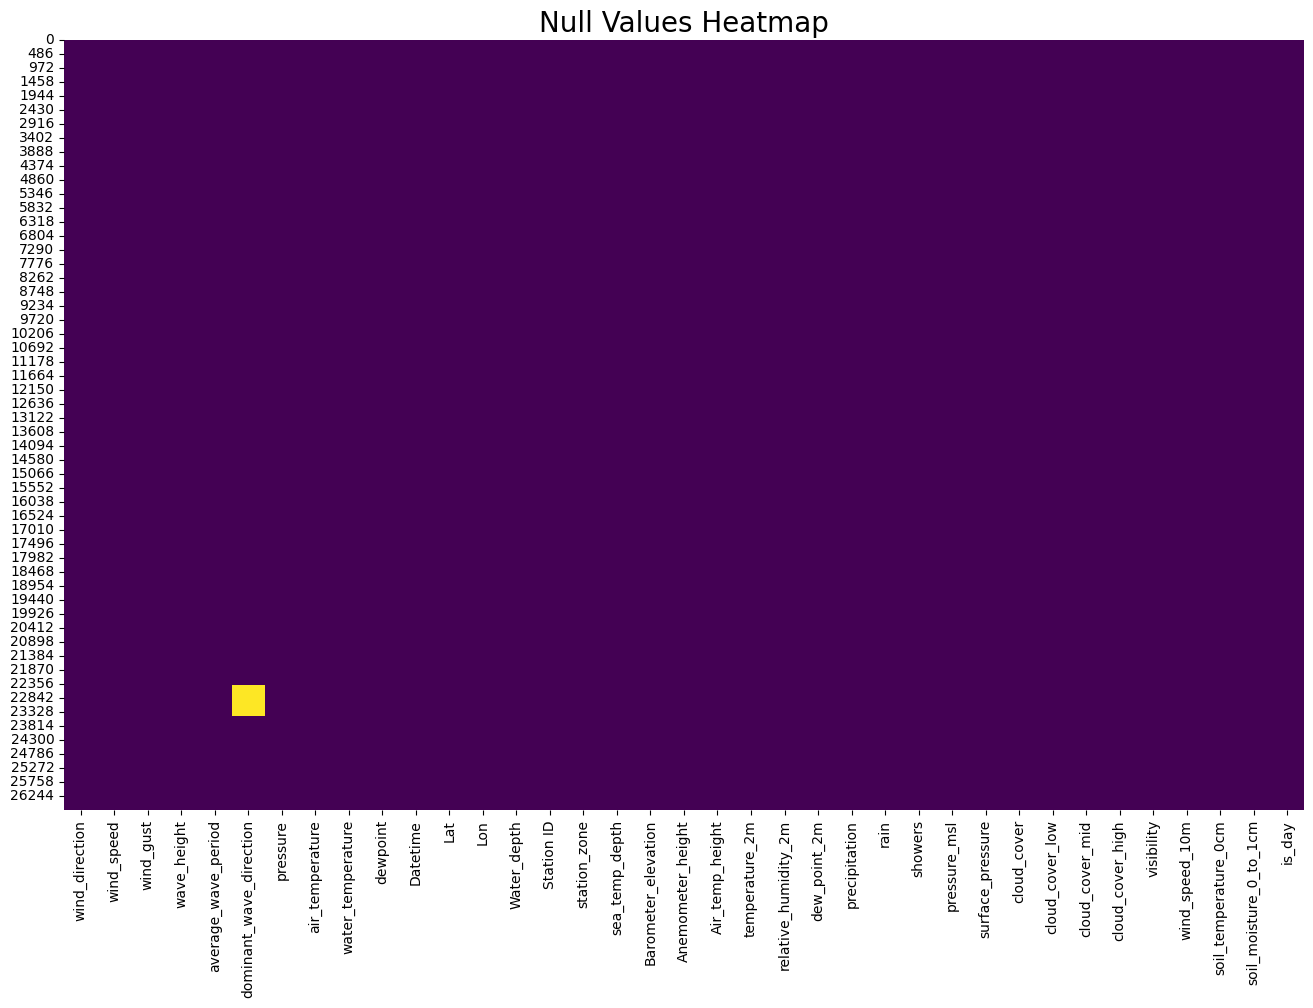

In [18]:
# null value heatmap with sns

plt.figure(figsize=(16, 10))

sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')

plt.title('Null Values Heatmap', fontdict={'size': 20})

plt.show()

In [19]:
df_final = handle_null_values(df_final)
display_row_values(df_final)


Tag: yellow - Nombre de lignes: 26725
Colonne 'wind_direction' non modifi√©e (0% de valeurs manquantes)
Colonne 'wind_speed' non modifi√©e (0% de valeurs manquantes)
Colonne 'wind_gust' non modifi√©e (0% de valeurs manquantes)
Colonne 'wave_height' non modifi√©e (0% de valeurs manquantes)
Colonne 'average_wave_period' non modifi√©e (0% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imput√©e par la m√©diane (4.06% de valeurs manquantes)
Colonne 'pressure' non modifi√©e (0% de valeurs manquantes)
Colonne 'air_temperature' non modifi√©e (0% de valeurs manquantes)
Colonne 'water_temperature' non modifi√©e (0% de valeurs manquantes)
Colonne 'dewpoint' non modifi√©e (0% de valeurs manquantes)
Colonne 'Datetime' non modifi√©e (0% de valeurs manquantes)
Colonne 'Lat' non modifi√©e (0% de valeurs manquantes)
Colonne 'Lon' non modifi√©e (0% de valeurs manquantes)
Colonne 'Water_depth' non modifi√©e (0% de valeurs manquantes)
Colonne 'Station ID' non modifi√©e (0% de valeurs manquantes

# Hour Filtering

In [20]:
try:
    df_final = df_final[['Datetime', 'Lat', 'Lon'] + [col for col in df_final.columns if col not in ['Datetime', 'Lat', 'Lon']]]
    # placer la colonne Datetime en %Y-%m-%d %H
    
    print(f"üöÄ DataFrame filtr√©e pour ne garder que les lignes √† l'heure pile: {df_final.shape[0]} lignes")

except Exception as e:
    print(str(e))
finally:
    display(df_final.columns)

üöÄ DataFrame filtr√©e pour ne garder que les lignes √† l'heure pile: 26725 lignes


Index(['Datetime', 'Lat', 'Lon', 'wind_direction', 'wind_speed', 'wind_gust',
       'wave_height', 'average_wave_period', 'dominant_wave_direction',
       'pressure', 'air_temperature', 'water_temperature', 'dewpoint',
       'Water_depth', 'Station ID', 'station_zone', 'sea_temp_depth',
       'Barometer_elevation', 'Anemometer_height', 'Air_temp_height',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

In [21]:
df_final.columns = [col.strip() for col in df_final.columns]

# Renaming and deleting useless columns

In [22]:
# Dictionnaire de renommage des colonnes
col_to_rename = {'temperature_2m': 'T¬∞(C¬∞)', 
                 'relative_humidity_2m': 'Relative Humidity (%)',
                 'dew_point_2m': 'Dew Point (¬∞C)', 
                 'precipitation': 'Precipitations (mm)',  
                 'pressure_msl':'Sea Level Pressure (hPa)', 
                 'cloud_cover_low':'Low Clouds (%)',
                 'cloud_cover_mid' : 'Middle Clouds (%)', 
                 'cloud_cover_high' : 'High Clouds (%)', 
                 'visibility' : 'Visibility (km)', 
                 'wind_direction': 'Wind Direction (¬∞)',
                 'wind_speed': 'Wind Speed (km/h)', 
                 'wind_gust': 'Wind Gusts (km/h)',
                 'wind_speed_10m':'Wind Speed (10m)', 
                 'surface_pressure': 'Surface Pressure',
                 'wave_height': 'Wave Height (m)', 
                 'average_wave_period': 'Average Wave Period (s)',
                 'dominant_wave_direction': 'Dominant Wave Direction (¬∞)', 
                 'pressure': 'Pressure (hPa)',
                 'air_temperature': 'Air T¬∞', 
                 'water_temperature': 'Water T¬∞', 
                 'Water_depth': 'Water Depth (m)', 
                 "Air_temp_height": "Air T¬∞ Height", 
                 "Anemometer_height": "Anemometer Height (m)", 
                 "station_zone": "Station Zone",
                 "Barometer_elevation": "Barometer Elevation", 
                 "sea_temp_depth" : "Sea Temperature Depth (m)",
                 "cloud_cover": "Cloud Cover (%)"
                 }

# Liste des colonnes √† supprimer
cols_to_delete = ['soil_temperature_0cm', 'lat_buoy','lon_buoy', 'rain', 
                  'showers', 'is_day', 'soil_moisture_0_to_1cm']
	
# Renommer les colonnes d'abord
df_final = rename_columns(df_final, col_to_rename)
# Ensuite, supprimer les colonnes non d√©sir√©es
df_final = drop_columns_if_exist(df_final, cols_to_delete)
try:
    if df_final['Visibility (km)'].mean() > 1000:
        df_final['Visibility (km)'] = df_final['Visibility (km)'] / 1000
        print("Conversion de la visibilit√© de m√®tres √† kilom√®tres")
    df_final["T¬∞(C¬∞)"] = round(df_final["T¬∞(C¬∞)"], 2)
    df_final["Wind Speed (10m)"] = round(df_final["Wind Speed (10m)"], 2)
except Exception as e:
    print(f"ÔøΩÔøΩ Erreur lors du traitement des colonnes :\n {e}")

# Afficher les r√©sultats
print("\nColonnes apr√®s renommage et suppression :")
print("\n")
display_row_values(df_final)

üîÑ Colonne 'temperature_2m' renomm√©e en 'T¬∞(C¬∞)'
üîÑ Colonne 'relative_humidity_2m' renomm√©e en 'Relative Humidity (%)'
üîÑ Colonne 'dew_point_2m' renomm√©e en 'Dew Point (¬∞C)'
üîÑ Colonne 'precipitation' renomm√©e en 'Precipitations (mm)'
üîÑ Colonne 'pressure_msl' renomm√©e en 'Sea Level Pressure (hPa)'
üîÑ Colonne 'cloud_cover_low' renomm√©e en 'Low Clouds (%)'
üîÑ Colonne 'cloud_cover_mid' renomm√©e en 'Middle Clouds (%)'
üîÑ Colonne 'cloud_cover_high' renomm√©e en 'High Clouds (%)'
üîÑ Colonne 'visibility' renomm√©e en 'Visibility (km)'
üîÑ Colonne 'wind_direction' renomm√©e en 'Wind Direction (¬∞)'
üîÑ Colonne 'wind_speed' renomm√©e en 'Wind Speed (km/h)'
üîÑ Colonne 'wind_gust' renomm√©e en 'Wind Gusts (km/h)'
üîÑ Colonne 'wind_speed_10m' renomm√©e en 'Wind Speed (10m)'
üîÑ Colonne 'surface_pressure' renomm√©e en 'Surface Pressure'
üîÑ Colonne 'wave_height' renomm√©e en 'Wave Height (m)'
üîÑ Colonne 'average_wave_period' renomm√©e en 'Average Wave Period (s

Transformer les coordonn√©es en format float

In [23]:
try:

    df_final[['Lat', 'Lon']] = df_final.apply(
        lambda row: pd.Series(convert_coordinates(row['Lat'], row['Lon'])),
        axis=1
    )
except Exception as e:
    print(f"Erreur : {e}")
finally:
    display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Air T¬∞  |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Surface Pressure  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Pressure and air temperatures are very close
We'll make the average of them all

In [24]:
try:
    df_final['T¬∞(C¬∞)'] = (df_final['Air T¬∞'] + df_final['T¬∞(C¬∞)']) / 2
    df_final['T¬∞(C¬∞)'] = df_final['T¬∞(C¬∞)'].round(2)
    df_final.drop(columns=['Air T¬∞'], inplace=True)
    
    df_final['Sea Level Pressure (hPa)'] = round((df_final['Sea Level Pressure (hPa)'] + df_final['Surface Pressure']) / 2, 2)
    df_final.drop(columns=['Surface Pressure'], inplace=True)
except Exception as e:
    print(f"Erreur :\n {e}")
    
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Create Categorical Time columns and delete the 'm' in Water Depth Column

In [25]:
try:
    # Cr√©er une colonne temporaire pour acc√©der √† .dt

    df_final['Year'] = df_final['Datetime'].dt.year
    df_final['Month'] = df_final['Datetime'].dt.month_name()
    df_final['DayOfWeek'] = df_final['Datetime'].dt.day_name()
    df_final['DayPeriod'] = df_final['Datetime'].apply(
        lambda x: 'Morning' if 6 <= x.hour < 12 else
                  'Afternoon' if 12 <= x.hour < 18 else
                  'Evening' if 18 <= x.hour < 22 else
                  'Night'
    )

except Exception as e:
    print(f"Erreur :\n {e}")

try:
    # virer le m dans Water Depth avec regex lambda et passer la colonne en float
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].apply(lambda x: re.sub(r'\D', '', str(x)).strip())
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].astype(float)
except Exception as e:
    print(str(e))

display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Check truth about Wind Speed Using another API call

In [26]:
df_42058 = df_final[df_final['Station ID'] == "42058"]
df_42058.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Pressure (hPa)', 'Water T¬∞', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T¬∞ Height', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'DayOfWeek', 'DayPeriod'],
      dtype='object')

# Requ√™te √† l'API Visual Crossing pour les donn√©es de v√©rification (1 / 24h)

In [27]:
# ---- Chargement de la cl√© API ----
vc_api_key_path = r"c:\Credentials\visual_crossing_weather_api.json"
with open(vc_api_key_path, 'r') as file:
    content = json.load(file)
    vc_api_key = content["api_key"]

# ---- Extraire les coordonn√©es depuis la premi√®re ligne du DataFrame ----
lat_42058, lon_42058 = None, None

if not df_42058.empty:
    first_row = df_42058.iloc[0]
    lat_42058, lon_42058 = first_row["Lat"], first_row["Lon"]

# ---- D√©finir les dates pour la requ√™te ----
today = datetime.now().strftime("%Y-%m-%d")
last_month = (datetime.now() - timedelta(days=31)).strftime("%Y-%m-%d")

# ---- Cr√©er le dossier de cache si n√©cessaire ----
cache_dir = "api_call_files"
os.makedirs(cache_dir, exist_ok=True)

# ---- D√©finir le fichier cache selon la position ----
cache_file = os.path.join(cache_dir, f"vc_meteo_{lat_42058}_{lon_42058}.csv")

# ---- V√©rifier si un cache r√©cent existe (moins de 24h) ----
use_cache = False
if os.path.exists(cache_file):
    last_modified = datetime.fromtimestamp(os.path.getmtime(cache_file))
    if datetime.now() - last_modified < timedelta(hours=24):
        print(f"üì¶ Cache d√©tect√© ({cache_file}), modifi√© le {last_modified.strftime('%Y-%m-%d %H:%M:%S')}")
        vc_meteo_df = pd.read_csv(cache_file)
        print("‚úÖ Donn√©es m√©t√©o recharg√©es depuis le cache.")
        use_cache = True
    else:
        print(f"‚ö†Ô∏è Cache trouv√© mais p√©rim√© (plus de 24h) ‚Üí nouvelle requ√™te API.")

# ---- Appel API si pas de cache valide ----
if not use_cache and lat_42058 is not None and lon_42058 is not None:
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat_42058},{lon_42058}/{last_month}/{today}?unitGroup=metric&key={vc_api_key}&contentType=json"
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
            vc_meteo_data = response.json()
            print("üåç Donn√©es m√©t√©o r√©cup√©r√©es depuis l'API Visual Crossing.")

            # ---- Extraire les donn√©es journali√®res et sauvegarder ----
            if "days" in vc_meteo_data:
                vc_meteo_df = pd.json_normalize(vc_meteo_data["days"])
                vc_meteo_df.to_csv(cache_file, index=False)
                print(f"üíæ Donn√©es sauvegard√©es dans le cache : {cache_file}")
            else:
                print("‚ö†Ô∏è Le champ 'days' est absent de la r√©ponse API.")
        else:
            print(f"‚ùå √âchec de l‚Äôappel API ‚Äî code de statut : {response.status_code}")
    except Exception as e:
        print(f"‚ùå Exception lev√©e lors de la requ√™te API : {e}")
        



# üìÅ Charger les donn√©es du CSV Visual Crossing
vc_csv_path = f"api_call_files/vc_meteo_{lat_42058}_{lon_42058}.csv"
df_vc_meteo = pd.read_csv(vc_csv_path)
try:
    # mettre Datetime en index
    df_vc_meteo.rename(columns={"datetime": "Datetime"}, inplace=True)  
    
except Exception as e:
    print(f"Erreur :\n {e}")

df_vc_meteo.head()

üì¶ Cache d√©tect√© (api_call_files\vc_meteo_14.51_-75.15.csv), modifi√© le 2025-04-17 10:41:04
‚úÖ Donn√©es m√©t√©o recharg√©es depuis le cache.


Datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2025-03-17     1742187600     27.5     26.5  27.3          30.8   
1  2025-03-18     1742274000     27.4     26.8  27.1          30.1   
2  2025-03-19     1742360400     27.4     26.7  27.2          30.3   
3  2025-03-20     1742446800     27.5     26.5  27.3          30.9   
4  2025-03-21     1742533200     27.9     26.0  27.4          32.3   

   feelslikemin  feelslike   dew  humidity  ...  sunriseEpoch    sunset  \
0          26.5       30.1  23.4      79.6  ...    1742209595  18:11:18   
1          28.7       29.4  22.4      75.7  ...    1742295953  18:11:25   
2          26.7       29.5  22.3      74.4  ...    1742382311  18:11:32   
3          26.5       29.9  22.9      77.4  ...    1742468669  18:11:39   
4          26.0       30.9  24.4      83.6  ...    1742555026  18:11:45   

   sunsetEpoch moonphase              conditions  \
0   1742253078      0.61        Partially cloudy   
1   1742339485      0.65        Partially cloudy   
2   1742425892      0.68                   Clear   
3   1742512299      0.71  Rain, Partially cloudy   
4   1742598705      0.74  Rain, Partially cloudy   

                                         description               icon  \
0                  Partly cloudy throughout the day.  partly-cloudy-day   
1                  Partly cloudy throughout the day.  partly-cloudy-day   
2               Clear conditions throughout the day.          clear-day   
3  Partly cloudy throughout the day with late aft...               rain   
4  Partly cloudy throughout the day with a chance...               rain   

                       stations  source  \
0  ['42058_maritime', 'remote']     obs   
1  ['42058_maritime', 'remote']     obs   
2  ['42058_maritime', 'remote']     obs   
3  ['42058_maritime', 'remote']     obs   
4  ['42058_maritime', 'remote']     obs   

                                               hours  
0  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
1  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
2  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
3  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
4  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  

[5 rows x 37 columns]

# Nettoyage du DataFrame retourn√©

In [28]:
# üßº Nettoyage et transformation
all_hours = []

for i, row in df_vc_meteo.iterrows():
    try:
        hours_list = ast.literal_eval(row['hours'])

        for hour_data in hours_list:
            hour_data['Date'] = i  # ‚úÖ On met l'index courant, i.e. la date du jour
            all_hours.append(hour_data)

    except Exception as e:
        print(f"Erreur parsing ligne {i}: {e}")

df_vc_flat = pd.DataFrame(all_hours)

# üïí Convertir le timestamp en datetime string
df_vc_flat["Datetime"] = pd.to_datetime(df_vc_flat["datetimeEpoch"], unit="s").dt.strftime("%Y-%m-%d-%H")

# üóìÔ∏è Filtrer sur les 30 derniers jours
today = datetime.now()
thirty_days_ago = today - timedelta(days=30)

df_vc_flat['Date'] = pd.to_datetime(df_vc_flat['Date'])  # üëà Assurer que c'est bien du datetime
df_vc_last_month = df_vc_flat[
    (df_vc_flat['Date'] >= thirty_days_ago) & 
    (df_vc_flat['Date'] <= today)
]


# Renommage des colonnes pour faciliter la comparaison

In [29]:
#Filtrer les colonnes n√©cessaires
try:
    df_vc_last_month = df_vc_last_month[["Datetime", "temp", "humidity", "precip", "dew", "windgust", 
                                     "windspeed", "winddir", "pressure", "visibility"]]
except Exception as e:
        print(f"Erreur lors du filtrage des colonnes:\n {e}\n")

try:
        df_vc_last_month["Datetime"] = pd.to_datetime(df_vc_last_month["Datetime"], errors='coerce')
except Exception as e:
        print(f"Erreur lors du reformatage de la colonne Datetime:\n {e}\n")        

for col in df_vc_last_month.columns:
        try:
            # 
            if not "Datetime" in col:
                if not col.startswith("VC_"):
                        rename_columns(df_vc_last_month, {col: f"VC_{col}"})
        except Exception as e:
                print(f"Erreur lors du renommage de la colonne {col}:\n {e}\n")


üîÑ Colonne 'temp' renomm√©e en 'VC_temp'
‚úÖ Colonnes renomm√©es : {'temp': 'VC_temp'}
üîÑ Colonne 'humidity' renomm√©e en 'VC_humidity'
‚úÖ Colonnes renomm√©es : {'humidity': 'VC_humidity'}
üîÑ Colonne 'precip' renomm√©e en 'VC_precip'
‚úÖ Colonnes renomm√©es : {'precip': 'VC_precip'}
üîÑ Colonne 'dew' renomm√©e en 'VC_dew'
‚úÖ Colonnes renomm√©es : {'dew': 'VC_dew'}
üîÑ Colonne 'windgust' renomm√©e en 'VC_windgust'
‚úÖ Colonnes renomm√©es : {'windgust': 'VC_windgust'}
üîÑ Colonne 'windspeed' renomm√©e en 'VC_windspeed'
‚úÖ Colonnes renomm√©es : {'windspeed': 'VC_windspeed'}
üîÑ Colonne 'winddir' renomm√©e en 'VC_winddir'
‚úÖ Colonnes renomm√©es : {'winddir': 'VC_winddir'}
üîÑ Colonne 'pressure' renomm√©e en 'VC_pressure'
‚úÖ Colonnes renomm√©es : {'pressure': 'VC_pressure'}
üîÑ Colonne 'visibility' renomm√©e en 'VC_visibility'
‚úÖ Colonnes renomm√©es : {'visibility': 'VC_visibility'}


Enforce Datetime Format

In [30]:
# Check if the Datetime column is correctly converted
print(df_42058["Datetime"].dtype)
print(df_vc_last_month["Datetime"].dtype)

datetime64[ns]
datetime64[ns]


Merge and Compare DataFrames

In [31]:
try:
    
    df_compare = pd.merge(df_42058, df_vc_last_month, on="Datetime", how="inner")
    display(df_compare.columns)
except Exception as e:
    print(e)

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Pressure (hPa)', 'Water T¬∞', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T¬∞ Height', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'DayOfWeek', 'DayPeriod',
       'VC_temp', 'VC_humidity', 'VC_precip', 'VC_dew', 'VC_windgust',
       'VC_windspeed', 'VC_winddir', 'VC_pressure', 'VC_visibility'],
      dtype='object')

Comparaison Wind Speed

In [32]:
try:
    # Wind Speed Comparison
    df_windspeed_compare = df_compare[['Wind Speed (km/h)', 'Wind Speed (10m)','VC_windspeed']]
    #  Pressure Comparison
    df_pressure_compare = df_compare[['Sea Level Pressure (hPa)','Pressure (hPa)', 'VC_pressure']]
    # Dew Point Comparison
    df_dew_compare = df_compare[['dewpoint','Dew Point (¬∞C)', 'VC_dew']]
except Exception as e:
    print(e)

df_windspeed_compare.head(10)

Empty DataFrame
Columns: [Wind Speed (km/h), Wind Speed (10m), VC_windspeed]
Index: []

In [33]:
wind_col_to_delete = ['Wind Speed (km/h)', 'Anemometer Height (m)']
df_final = drop_columns_if_exist(df_final, wind_col_to_delete)
# Arrondir les valeurs de df_final

df_final = df_final.round(2)

 Nombre initial de colonnes: 34
Colonne 'Wind Speed (km/h)' Supprim√©e
Colonne 'Anemometer Height (m)' Supprim√©e
 Nombre final de colonnes: 32


Comparaison Pressure

In [34]:
df_pressure_compare.head()

Empty DataFrame
Columns: [Sea Level Pressure (hPa), Pressure (hPa), VC_pressure]
Index: []

In [35]:
df_final = drop_columns_if_exist(df_final, ['Pressure (hPa)'])

 Nombre initial de colonnes: 32
Colonne 'Pressure (hPa)' Supprim√©e
 Nombre final de colonnes: 31


In [36]:
df_dew_compare.head()

Empty DataFrame
Columns: [dewpoint, Dew Point (¬∞C), VC_dew]
Index: []

Code Custom GPT Wisdom of crowd pour le DewPoint

In [37]:
try:

    # Calcul des distances absolues entre chaque paire de mesures pour chaque ligne
    # Ces distances nous permettent de savoir quelle mesure est la plus proche des autres
    df_compare['dist_dewpoint_DewPoint'] = np.abs(df_compare['dewpoint'] - df_compare['Dew Point (¬∞C)'])
    df_compare['dist_dewpoint_VC'] = np.abs(df_compare['dewpoint'] - df_compare['VC_dew'])
    df_compare['dist_DewPoint_VC'] = np.abs(df_compare['Dew Point (¬∞C)'] - df_compare['VC_dew'])

    # Pour chaque ligne, on d√©termine quelle mesure est la plus proche des deux autres :
    # - Si 'dewpoint' est plus proche des autres mesures que 'Dew Point (¬∞C)' et 'VC_dew', alors 'dewpoint' est marqu√© comme plus proche.
    df_compare['dewpoint_closer'] = (df_compare['dist_dewpoint_VC'] < df_compare['dist_dewpoint_DewPoint']) & (df_compare['dist_dewpoint_VC'] < df_compare['dist_DewPoint_VC'])

    # - Si 'Dew Point (¬∞C)' est plus proche des autres mesures que 'dewpoint' et 'VC_dew', alors 'Dew Point (¬∞C)' est marqu√© comme plus proche.
    df_compare['DewPoint_closer'] = (df_compare['dist_dewpoint_DewPoint'] < df_compare['dist_dewpoint_VC']) & (df_compare['dist_dewpoint_DewPoint'] < df_compare['dist_DewPoint_VC'])

    # - Si 'VC_dew' est plus proche des autres mesures que 'dewpoint' et 'Dew Point (¬∞C)', alors 'VC_dew' est marqu√© comme plus proche.
    df_compare['VC_closer'] = (df_compare['dist_DewPoint_VC'] < df_compare['dist_dewpoint_VC']) & (df_compare['dist_DewPoint_VC'] < df_compare['dist_dewpoint_DewPoint'])

    # Calculer les probabilit√©s que chaque mesure soit la plus proche des autres sur l'ensemble des lignes :
    # La probabilit√© est simplement la proportion de fois o√π une mesure a √©t√© plus proche des autres.
    prob_dewpoint_closer = df_compare['dewpoint_closer'].mean().round(3)
    prob_dewpoint_c_closer = df_compare['DewPoint_closer'].mean().round(3)
    prob_vc_closer = df_compare['VC_closer'].mean().round(3)

    # Afficher les r√©sultats
    # Ces r√©sultats indiquent la probabilit√© que chaque mesure soit la plus proche des autres sur toutes les lignes de donn√©es
    print(f"Probability that 'dewpoint' is closer to the truth: {prob_dewpoint_closer}")
    print(f"Probability that 'Dew Point (¬∞C)' is closer to the truth: {prob_dewpoint_c_closer}")
    print(f"Probability that 'VC_dew' is closer to the truth: {prob_vc_closer}")
    
except Exception as e:
    print(e)

'float' object has no attribute 'round'


In [38]:
try:
    df_final['Dew Point (¬∞C)'] = df_final['dewpoint']
    df_final = drop_columns_if_exist(df_final, ['dewpoint'])
    
except Exception as e:
    print(e)
display_row_values(df_final)

 Nombre initial de colonnes: 31
Colonne 'dewpoint' Supprim√©e
 Nombre final de colonnes: 30
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Rename Final Columns

In [39]:
try:
    df_final.rename(columns={'Air T¬∞ Height': 'Air T¬∞ Height (m)',
                             'Barometer Elevation': 'Barometer Elevation (m)',
                             'Water T¬∞': 'Water T¬∞ (¬∞C)'}, inplace=True)

    print("Column 'Air T¬∞ Height' renamed to 'Air T¬∞ Height (m)'")

    print("Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'")
    print("Column 'Water T¬∞' renamed to 'Water T¬∞ (¬∞C)'")
    df_final['T¬∞(C¬∞)'] = df_final['T¬∞(C¬∞)'].round(2)

    print("Column 'T¬∞(C¬∞)' rounded to 2 decimal places")
except Exception as e:
    print(e)
    
display_row_values(df_final)

Column 'Air T¬∞ Height' renamed to 'Air T¬∞ Height (m)'
Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'
Column 'Water T¬∞' renamed to 'Water T¬∞ (¬∞C)'
Column 'T¬∞(C¬∞)' rounded to 2 decimal places
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Wind Direction (¬∞)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Water T¬∞ (¬∞C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T¬∞ Height (m)                      object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)            

In [41]:
# Correction des types des colonnes
try:
    df_final['Lat'] = df_final['Lat'].astype(str)
    df_final['Lon'] = df_final['Lon'].astype(str)
    df_final['Year'] = df_final['Year'].astype(str)
    print(df_final.dtypes)
except Exception as e:
    print(e)

Datetime                       datetime64[ns]
Lat                                    object
Lon                                    object
Wind Direction (¬∞)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Water T¬∞ (¬∞C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T¬∞ Height (m)                      object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)            

In [42]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
table_silver = "silver_table"
table_dim_station = "dim_station"
table_dim_time = "dim_time"
table_facts_meteo = "facts_meteo"
table_facts_ocean = "facts_ocean"

In [44]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [68]:
df_final["Date ID"] = df_final["Datetime"].astype(str)

In [69]:
def insert_new_rows(df: pd.DataFrame, engine, table_name: str, ref: str):
    """
    Ins√®re uniquement les nouvelles lignes dans une table MySQL existante
    en comparant une colonne de r√©f√©rence dans le DataFrame avec la m√™me colonne dans la table.
    """
    
    # R√©cup√©rer les m√©tadonn√©es des tables existantes
    metadata = MetaData()
    metadata.reflect(bind=engine)

    # V√©rifier que la table existe dans la base
    if table_name not in metadata.tables:
        raise ValueError(f"La table '{table_name}' n'existe pas dans la base de donn√©es.")
    
    # Acc√©der √† la table
    table = metadata.tables[table_name]
    
    # V√©rifier si la colonne de r√©f√©rence existe dans la table
    if ref not in table.columns:
        raise ValueError(f"La colonne de r√©f√©rence '{ref}' n'existe pas dans la table.")
    
    # R√©cup√©rer toutes les valeurs de la colonne de r√©f√©rence d√©j√† pr√©sentes dans la base
    with engine.connect() as conn:
        stmt = select(table.c[ref])  # S√©lectionner la colonne de r√©f√©rence
        existing_values = {row[0] for row in conn.execute(stmt)}  # Ensemble des valeurs existantes

    print(f"üîé {len(existing_values)} valeurs d√©j√† pr√©sentes dans la colonne '{ref}'.")

    # Garder uniquement les lignes o√π la valeur de `ref` n'est pas d√©j√† dans la table
    new_df = df[~df[ref].isin(existing_values)]

    # Si aucune nouvelle ligne √† ins√©rer
    if new_df.empty:
        print("‚ö†Ô∏è Aucune nouvelle ligne √† ins√©rer.")
        return

    print(f"üöÄ Insertion de {len(new_df)} lignes dans '{table_name}'...")

    # Insertion des nouvelles lignes dans la base de donn√©es
    new_df.to_sql(
        name=table_name,            # Nom de la table cible
        con=engine,                 # Connexion SQLAlchemy
        if_exists='append',         # Ajouter sans supprimer les donn√©es existantes
        index=False,                # Ne pas utiliser l'index comme colonne
        chunksize=1000              # Insertion par lots de 1000 lignes
    )

    print("‚úÖ Insertion termin√©e avec succ√®s.")

try:
    #Supprimer la colonne 'Datetime'
    
    create_table_in_mysql(df=df_final, engine=engine, table_name=table_silver)
except Exception as e:
    print(f"Error when creating table:\n {str(e)}")
try:
    insert_new_rows(df=df_final, engine=engine, table_name=table_silver, ref= 'Date ID')
except Exception as e:
    print(f"Error when inserting new rows:\n {str(e)}")

‚úÖ Table 'silver_table' cr√©√©e avec succ√®s via SQLAlchemy.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Date ID'.
üöÄ Insertion de 26725 lignes dans 'silver_table'...
‚úÖ Insertion termin√©e avec succ√®s.


In [46]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 

Cr√©ation des DataFrames pour les tables

In [47]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                    object
Lon                                    object
Wind Direction (¬∞)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Water T¬∞ (¬∞C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T¬∞ Height (m)                      object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)            

In [48]:
# Nettoyer 'Station ID'
df_final['Station ID'] = df_final['Station ID'].astype(str).str.strip()

# Colonnes d√©riv√©es
df_final['Date ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H')
df_final['Unique ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H%M') + df_final['Station ID']


In [49]:
#imprimer toutes les colonnes numeriquesq
num_cols = df_final.select_dtypes(include=[np.number]).columns

#imprimer toutes les colonnes non-numeriques

non_num_cols = df_final.select_dtypes(exclude=[np.number]).columns
non_num_cols

Index(['Datetime', 'Lat', 'Lon', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
       'Air T¬∞ Height (m)', 'Year', 'Month', 'DayOfWeek', 'DayPeriod',
       'Date ID', 'Unique ID'],
      dtype='object')

In [50]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod  |  Date ID     |  Unique ID        
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
##################################### DimStation ##################################################################################################

df_station = df_final[[
    'Station ID', 'Station Zone', 'Lat', 'Lon'
]].copy().drop_duplicates()

###################################### DimTime ##################################################################################################

df_time = df_final[['Datetime', 'Year', 'Month', 'DayOfWeek', 'DayPeriod']].copy().drop_duplicates()

########################################## Facts Meteo #########################################################################

df_facts_meteo = df_final[[
    'Unique ID', # PK
    'T¬∞(C¬∞)', 'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
    'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
    "Cloud Cover (%)", 'Visibility (km)', 'Wind Speed (10m)', 'Wind Direction (¬∞)',
    'Wind Gusts (km/h)', 'Barometer Elevation (m)', 'Air T¬∞ Height (m)',
    
    'Station ID', # FK
    'Datetime' # FK
]].copy().drop_duplicates()

########################################## Facts Ocean #########################################################################

df_facts_ocean = df_final[[
    'Unique ID', # PK
    'Wave Height (m)', 'Average Wave Period (s)', 'Dominant Wave Direction (¬∞)',
    'Water T¬∞ (¬∞C)', 'Water Depth (m)', 'Sea Temperature Depth (m)',
    
    'Station ID', # FK
    'Datetime'  # FK
]].copy().drop_duplicates()


In [52]:
display_row_values(df_time)

Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------
0      |  2025-04-18 07:00:00  |  2025  |  April  |  Friday     |  Morning  
1      |  2025-04-18 06:00:00  |  2025  |  April  |  Friday     |  Morning  
2      |  2025-04-18 05:00:00  |  2025  |  April  |  Friday     |  Night    
3      |  2025-04-18 04:00:00  |  2025  |  April  |  Friday     |  Night    
4      |  2025-04-18 03:00:00  |  2025  |  April  |  Friday     |  Night    
5      |  2025-04-18 02:00:00  |  2025  |  April  |  Friday     |  Night    
6      |  2025-04-18 01:00:00  |  2025  |  April  |  Friday     |  Night    
7      |  2025-04-18 00:00:00  |  2025  |  April  |  Friday     |  Night    
8      |  2025-04-17 23:00:00  |  2025  |  April  |  Thursday   |  Night    
9      |  2025-04-17 22:00:00  |  2025  |  April  |  Thursday   |  Night    


In [53]:
display_row_values(df_station)

Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41008       |  grays reef                                |  31.4   |  -80.87 
1087   |  41044       |  ne st martin                              |  21.58  |  -58.63 
2166   |  41049       |  south bermuda                             |  27.5   |  -62.27 
3253   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
4119   |  42002       |  west gulf                                 |  25.95  |  -93.78 
5009   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
6096   |  42036       |  west tampa                                |  28.5   |  -84.5  
7174   |  42056       |  yucatan basin                             |  19.82  |  -84.98 
8261   |  42058       |  central caribbean                         |  14.51  |  -75.15 
9345   |  44007       |  portland   

In [54]:
display_row_values(df_facts_meteo)

Index  |  Unique ID          |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  Station ID  |  Datetime           
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250418070041008  |  20.7    |  88.0                   |  18.1            |  0.0                  |  1022.1                    |  2.0             |  0.0                |  0.0              |  2.0              |  17.2 

In [55]:
display_row_values(df_facts_ocean)

Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250418070041008  |  0.9              |  4.6                      |  108.0                        |  20.7           |  16.0             |  2                          |  41008       |  2025-04-18 07:00:00
1      |  20250418060041008  |  0.9              |  4.6                      |  108.0                        |  20.6           |  16.0             |  2                          |  41008       |  2025-04-18 06:00:00
2      |  20250418050041008  |  0.9              |  4.6                      |  108.0                        |  20.6           |  16.0            

In [56]:
# V√©rifier les doublons
print(f"Doublons dans df_station : {df_station.duplicated().sum()}")
print(f"Doublons dans df_time : {df_time.duplicated().sum()}")
print(f"Doublons dans df_facts_meteo : {df_facts_meteo.duplicated().sum()}")
print(f"Doublons dans df_facts_ocean : {df_facts_ocean.duplicated().sum()}")

# V√©rification des valeurs de base
print(f"\nDescription des donn√©es de df_station : \n{df_station.describe()}")
print(f"\nDescription des donn√©es de df_time : \n{df_time.describe()}")
print(f"\nDescription des donn√©es de df_facts_meteo : \n{df_facts_meteo.describe()}")
print(f"\nDescription des donn√©es de df_facts_ocean : \n{df_facts_ocean.describe()}")

Doublons dans df_station : 0
Doublons dans df_time : 0
Doublons dans df_facts_meteo : 0
Doublons dans df_facts_ocean : 0

Description des donn√©es de df_station : 
       Station ID Station Zone   Lat     Lon
count          25           25    25      25
unique         25           25    25      25
top         41008   grays reef  31.4  -80.87
freq            1            1     1       1

Description des donn√©es de df_time : 
                  Datetime
count                 1088
mean   2025-03-26 15:30:00
min    2025-03-04 00:00:00
25%    2025-03-15 07:45:00
50%    2025-03-26 15:30:00
75%    2025-04-06 23:15:00
max    2025-04-18 07:00:00

Description des donn√©es de df_facts_meteo : 
             T¬∞(C¬∞)  Relative Humidity (%)  Dew Point (¬∞C)  \
count  26725.000000           26725.000000    26725.000000   
mean      15.093607              79.360489       11.864314   
min       -2.850000              25.000000      -14.900000   
25%        7.600000              73.000000        4.90000

Checking dim_station DataFrame

In [57]:
# check unique values
print(f"{df_station.shape[0]}\n\n{df_station.nunique()}")
display_row_values(df_station)

25

Station ID      25
Station Zone    25
Lat             25
Lon             25
dtype: int64
Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41008       |  grays reef                                |  31.4   |  -80.87 
1087   |  41044       |  ne st martin                              |  21.58  |  -58.63 
2166   |  41049       |  south bermuda                             |  27.5   |  -62.27 
3253   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
4119   |  42002       |  west gulf                                 |  25.95  |  -93.78 
5009   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
6096   |  42036       |  west tampa                                |  28.5   |  -84.5  
7174   |  42056       |  yucatan basin                             |  19.82  |  -84.98 
8261   |  42058       |  centra

Cr√©ation de la table dim_station et insertion des donn√©es

In [58]:
try:
    create_table_in_mysql(df=df_station, engine=engine, table_name=table_dim_station)
    insert_new_rows(df=df_station, engine=engine, table_name=table_dim_station, ref='Datetime')
except Exception as e:
    print(e)

‚úÖ Table 'dim_station' cr√©√©e avec succ√®s via SQLAlchemy.
La colonne de r√©f√©rence 'Datetime' n'existe pas dans la table.


Checking dim_time DataFrame

In [59]:
print(f"{df_time.shape[0]}\n\n{df_time.nunique()}")
display_row_values(df_time)

1088

Datetime     1088
Year            1
Month           2
DayOfWeek       7
DayPeriod       4
dtype: int64
Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------
0      |  2025-04-18 07:00:00  |  2025  |  April  |  Friday     |  Morning  
1      |  2025-04-18 06:00:00  |  2025  |  April  |  Friday     |  Morning  
2      |  2025-04-18 05:00:00  |  2025  |  April  |  Friday     |  Night    
3      |  2025-04-18 04:00:00  |  2025  |  April  |  Friday     |  Night    
4      |  2025-04-18 03:00:00  |  2025  |  April  |  Friday     |  Night    
5      |  2025-04-18 02:00:00  |  2025  |  April  |  Friday     |  Night    
6      |  2025-04-18 01:00:00  |  2025  |  April  |  Friday     |  Night    
7      |  2025-04-18 00:00:00  |  2025  |  April  |  Friday     |  Night    
8      |  2025-04-17 23:00:00  |  2025  |  April  |  Thursday   |  Night    
9      |  2025-04-17 22:00:00  |  2025  |  April 

Cr√©ation de la table dim_time et insertion des donn√©es

In [60]:
try:
    create_table_in_mysql(df=df_time, engine=engine, table_name=table_dim_time)
    insert_new_rows(df=df_time, engine=engine, table_name=table_dim_time, ref='Datetime')
except Exception as e:
    print(e)

‚úÖ Table 'dim_time' cr√©√©e avec succ√®s via SQLAlchemy.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
üöÄ Insertion de 1088 lignes dans 'dim_time'...
‚úÖ Insertion termin√©e avec succ√®s.


Checking Meteo Facts DataFrame

In [61]:
print(f"{df_facts_meteo.shape[0]}\n\n{df_facts_meteo.nunique()}")
display_row_values(df_facts_meteo)

26725

Unique ID                   26725
T¬∞(C¬∞)                       1718
Relative Humidity (%)          73
Dew Point (¬∞C)                384
Precipitations (mm)            73
Sea Level Pressure (hPa)      566
Low Clouds (%)                101
Middle Clouds (%)             101
High Clouds (%)               101
Cloud Cover (%)               101
Visibility (km)              1267
Wind Speed (10m)             3675
Wind Direction (¬∞)             36
Wind Gusts (km/h)              28
Barometer Elevation (m)         3
Air T¬∞ Height (m)               3
Station ID                     25
Datetime                     1088
dtype: int64
Index  |  Unique ID          |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  

Cr√©ation de la table facts_meteo et insertion des donn√©es

In [62]:
try:
    create_table_in_mysql(df=df_facts_meteo, engine=engine, table_name=table_facts_meteo)
    insert_new_rows(df=df_facts_meteo, engine=engine, table_name=table_facts_meteo, ref='Datetime')
except Exception as e:
    print(e)

‚úÖ Table 'facts_meteo' cr√©√©e avec succ√®s via SQLAlchemy.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
üöÄ Insertion de 26725 lignes dans 'facts_meteo'...
‚úÖ Insertion termin√©e avec succ√®s.


Checking Ocean Facts DataFrame

In [63]:
print(f"{df_facts_ocean.shape[0]}\n\n{df_facts_ocean.nunique()}")
display_row_values(df_facts_ocean)

26725

Unique ID                      26725
Wave Height (m)                   40
Average Wave Period (s)           61
Dominant Wave Direction (¬∞)      162
Water T¬∞ (¬∞C)                    271
Water Depth (m)                   25
Sea Temperature Depth (m)          3
Station ID                        25
Datetime                        1088
dtype: int64
Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250418070041008  |  0.9              |  4.6                      |  108.0                        |  20.7           |  16.0             |  2                          |  41008       |  2025-04-18 07:00:00
1    

Cr√©ation de la table facts_ocean et insertion des donn√©es

In [64]:
try:
    create_table_in_mysql(df=df_facts_ocean, engine=engine, table_name=table_facts_ocean)
    insert_new_rows(df=df_facts_ocean, engine=engine, table_name=table_facts_ocean, ref='Datetime')
except Exception as e:
    print(e)

‚úÖ Table 'facts_ocean' cr√©√©e avec succ√®s via SQLAlchemy.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
üöÄ Insertion de 26725 lignes dans 'facts_ocean'...
‚úÖ Insertion termin√©e avec succ√®s.


In [65]:
# try:
#     # Initialiser le metadata
#     metadata = MetaData()
#     metadata.reflect(bind=engine)

#     # R√©cup√©rer les tables existantes
#     dim_station = metadata.tables['dim_station']
#     dim_time = metadata.tables['dim_time']
#     facts_meteo = metadata.tables['facts_meteo']
#     facts_ocean = metadata.tables['facts_ocean']

#     # Ajouter les cl√©s √©trang√®res aux tables de faits
#     ForeignKeyConstraint(['Station ID'], [dim_station.c['Station ID']], name='fk_meteo_station').create(facts_meteo, bind=engine)
#     ForeignKeyConstraint(['Datetime'], [dim_time.c['Datetime']], name='fk_meteo_time').create(facts_meteo, bind=engine)

#     ForeignKeyConstraint(['Station ID'], [dim_station.c['Station ID']], name='fk_ocean_station').create(facts_ocean, bind=engine)
#     ForeignKeyConstraint(['Datetime'], [dim_time.c['Datetime']], name='fk_ocean_time').create(facts_ocean, bind=engine)
# except Exception as e:
#     print(str(e))